<a href="http://www.persistent-identifier.nl/?identifier=urn%3Anbn%3Anl%3Aui%3A13-048i-71" target="_blank"><img align="left"src="images/etcbc4easy-small.png"/></a>
<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-xsmall.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="right" src="images/VU-ETCBC-xsmall.png"/></a>

# Kings and parallels

Joint work of Martijn Naaijer and Dirk Roorda.

This is a case study to 2 Kings 19-25 and passages that run partly parallel to these chapters.
These variants occur in Chronicles, Isaiah and Jeremiah.

We find the variants by using the database of cross references made by the 
[cross ref tool in SHEBANQ](https://shebanq.ancient-data.org/tools?goto=parallel).

## Results

* Graph of parallels. See below or [download as pdf](kings_parallels.pdf).
* Synoptic view of the main portions. 
  In [Hebrew](kings_parallels_h.html) or [phonetic](kings_parallels_p.html).
* Chapter diffs of the relevant chapters in Jesaia, between the Masoretic text and the Qumran text.
  [Jesaia 37](jesaia-mt-1q_37.html)
  [Jesaia 38](jesaia-mt-1q_38.html)
  [Jesaia 39](jesaia-mt-1q_39.html).
* [Sentence similarities](kings_similarities.tsv) between the sentences in the relevant verses.
* Plot of sentence similarities. See below or [download as pdf](kings_similarities.pdf).

In [3]:
import sys,os, re, pickle
import collections, difflib
from Levenshtein import ratio

from IPython.display import HTML, display_pretty, display_html
from difflib import SequenceMatcher
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import laf
from laf.fabric import LafFabric
from etcbc.preprocess import prepare
from etcbc.lib import Transcription
fabric = LafFabric()

  0.00s This is LAF-Fabric 4.5.12
API reference: http://laf-fabric.readthedocs.org/en/latest/texts/API-reference.html
Feature doc: https://shebanq.ancient-data.org/static/docs/featuredoc/texts/welcome.html



In [4]:
source = 'etcbc'
version = '4b'

In [5]:
API = fabric.load(source+version, 'lexicon', 'kings', {
    "xmlids": {"node": False, "edge": False},
    "features": ('''
        otype
        language lex lex_utf8 g_cons_utf8 g_word_utf8 trailer_utf8 phono phono_sep
        book chapter verse label number
    ''',''),
    "prepare": prepare,
    "primary": False,
}, verbose='NORMAL')
exec(fabric.localnames.format(var='fabric'))

  0.00s LOADING API: please wait ... 
  0.00s USING main  DATA COMPILED AT: 2015-11-02T15-08-56
  0.00s USING annox DATA COMPILED AT: 2016-01-27T19-01-17
  5.05s LOGFILE=/Users/dirk/SURFdrive/laf-fabric-output/etcbc4b/kings/__log__kings.txt
  5.05s INFO: LOADING PREPARED data: please wait ... 
  5.05s prep prep: G.node_sort
  5.18s prep prep: G.node_sort_inv
  5.72s prep prep: L.node_up
  9.17s prep prep: L.node_down
    16s prep prep: V.verses
    16s ETCBC reference: http://laf-fabric.readthedocs.org/en/latest/texts/ETCBC-reference.html
    17s INFO: LOADED PREPARED data
    17s INFO: DATA LOADED FROM SOURCE etcbc4b AND ANNOX lexicon FOR TASK kings AT 2016-02-25T16-25-09


## Config information.

In [6]:
REFBOOKS = {'Reges_II'}
REFCHAPTERS = set(range(19,26))

Q1_FILE = 'qisaa_an.txt'
SHEBANQ_PATH = os.path.abspath('{}/../../../shebanq'.format(os.getcwd))

CROSSREF_APP = 'parallel'
PRECOMP_DIR = '{}/{}{}/{}/{}'.format(API['output_dir'], source, version, CROSSREF_APP, 'stored')
MATRIX_GREP = '{}/matrices/matrix_{}_{}_{}_{}'.format(PRECOMP_DIR, 'O', 'verse', 'SET', 50)
CHUNK_GREP = '{}/chunks/chunk_{}_{}'.format(PRECOMP_DIR, 'O', 'verse')

SIM_THRESHOLD_GREP = 60

PASSAGE_FMT = '{}~{}:{}'
PASSAGER_FMT = '{}r~{}:{}'

NCOL_FILE = 'kings_crossrefs.ncol'
SIMILAR_FILE = 'kings_similarities.tsv'

## Book name index

We want to discuss the portion of ``Reges_II`` that we are interested in separately from the other chapters.
That is why we introduce a virtual book ``Reges_IIr`` for our reference chapters.

In [7]:
book_node = dict()
for b in F.otype.s('book'):
    book_name = F.book.v(b)
    book_node[book_name] = b
    if book_name == 'Reges_II': 
        book_node[book_name+'r'] = b

# Grep all parallel verses

The first stage consists of grabbing all verses that are detected as parallel to one of the verses of our reference chapters.

In [8]:
def get_verse_ref(chunk):
    vn = L.u('verse', chunks[chunk][0])
    return (vn, (F.book.v(vn), int(F.chapter.v(vn)), int(F.verse.v(vn))))

In [9]:
with open(MATRIX_GREP, 'rb') as f: grep_dist = pickle.load(f)
with open(CHUNK_GREP, 'rb') as f: chunks = pickle.load(f)

all_verse_nodes = set()
n_internal = 0
x = 0
crossrefs = set()
for ((c1, c2), r) in grep_dist.items():
    if r < SIM_THRESHOLD_GREP: continue
    (v1, (bk1, ch1, vs1)) = get_verse_ref(c1)
    (v2, (bk2, ch2, vs2)) = get_verse_ref(c2)
    if bk1 in REFBOOKS and ch1 in REFCHAPTERS and bk2 in REFBOOKS and ch2 in REFCHAPTERS:
        n_internal += 1
        continue
    elif bk1 in REFBOOKS and ch1 in REFCHAPTERS:
        bkx = bk1
        chx = ch1
        vsx = vs1
        bky = bk2
        chy = ch2
        vsy = vs2
    elif bk2 in REFBOOKS and ch2 in REFCHAPTERS:
        bkx = bk2
        chx = ch2
        vsx = vs2
        bky = bk1
        chy = ch1
        vsy = vs1
    else:
        continue
    crossrefs.add(((bkx, chx, vsx), (bky, chy, vsy), r))
    all_verse_nodes |= {v1, v2}

msg('{} external crossrefs saved; {} internal crossrefs skipped; from total {} crossrefs'.format(
    len(crossrefs), n_internal, len(grep_dist),
))

print('\n'.join('{}r\t{}\t{}\t{}\t{}\t{}\t{}'.format(*x[0], *x[1], round(x[2])) for x in sorted(crossrefs)[0:10]))

    13s 276 external crossrefs saved; 22 internal crossrefs skipped; from total 24832 crossrefs


Reges_IIr	19	1	Jesaia	37	1	100
Reges_IIr	19	2	Jesaia	37	2	100
Reges_IIr	19	3	Jesaia	37	3	100
Reges_IIr	19	4	Jesaia	37	4	95
Reges_IIr	19	5	Jesaia	37	5	100
Reges_IIr	19	6	Jesaia	37	6	100
Reges_IIr	19	7	Jesaia	37	7	100
Reges_IIr	19	8	Jesaia	37	8	100
Reges_IIr	19	9	Jesaia	37	9	79
Reges_IIr	19	10	Jesaia	37	10	100


The next cell will produce 

* an edge list in NCOL_FILE, ready to be imported by networkx;
* a set of all verses encountered
* a set of all chapters encountered
* a set of all books encountered

In [10]:
msg('Exporting graph info, assembling sets')
ncolfile = open(NCOL_FILE, 'w')
for (x, y, r) in sorted(crossrefs, key=lambda z: (
        book_node[z[0][0]], z[0][1], z[0][2], 
        book_node[z[1][0]], z[1][1], z[1][2],
)):
    ncolfile.write('{} {} {}\n'.format(PASSAGER_FMT.format(*x), PASSAGE_FMT.format(*y), round(r)))
ncolfile.close()

all_verses = {(x[0][0]+'r', x[0][1], x[0][2]) for x in crossrefs} | {x[1] for x in crossrefs}
all_chapters = {(x[0], x[1]) for x in all_verses}
all_books = {x[0] for x in all_chapters}
msg('{} edges, {} verses, {} chapters, {} books'.format(
    len(crossrefs), len(all_verses), len(all_chapters), len(all_books),
))
print(' '.join(sorted(all_books)))

    18s Exporting graph info, assembling sets
    18s 276 edges, 296 verses, 46 chapters, 10 books


Chronica_II Deuteronomium Exodus Ezechiel Haggai Jeremia Jesaia Reges_I Reges_II Reges_IIr


# Qumran Scroll 1Q

Read it.

In [11]:
trans_final_pat = re.compile('([KMNPY])(?= |\Z)')

def trans_final_repl(match): return match.group(1).lower()

msg('reading Q1')
qf = open(Q1_FILE)
q1 = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
nwords = 0
for line in qf:
    nwords += 1
    (passage, word, xword) = line.strip().split()
    (chapter, verse) = passage.split(',')
    word = trans_final_pat.sub(trans_final_repl, word)
    q1[int(chapter)][int(verse)].append(Transcription.to_hebrew_x(word))
qf.close()
msg('{} words in {} chapters in {} verses'.format(nwords, len(q1), sum(len(q1[x]) for x in q1)))

    22s reading Q1
    22s 16862 words in 66 chapters in 1290 verses


In [12]:
print(' '.join(q1[1][1]))

חזון ישׁעיהו בן אמוץ אשׁר חזה על יהודה וירושׁלם ביומי עוזיה יותם אחז יחזקיה מלכי יהודה


# Graph
We now visualize the similarities in a graph, using networkx.
We firmly determine the layout, not following any of the methods provided by networkx.

We put the verses into columns by the book they occurr in.
We order the rows of verses according to their order in the text.

Finally, we shift rows of verses up and down in order to aline them with their parallel stretches.

We add a virtual book, ``Reges_IIr`` which is the book Reges_II restricted to the reference chapters. ``Reges_II`` stands for the other chapters of 2 Kings.

In [13]:
g = nx.read_weighted_edgelist(NCOL_FILE)

Compute the colors and the offsets of the nodes.

In [14]:
all_books_cust = '''
    Jeremia Chronica_II Jesaia Reges_IIr Reges_I Reges_II Deuteronomium Exodus Ezechiel Haggai 
'''.strip().split()

gcolors = dict(
    Reges_IIr=(0.9, 0.9, 0.9),
    Jesaia=(1.0, 0.3, 0.3),
    Jeremia=(0.3, 1.0, 0.3),
    Chronica_II=(1.0, 0.3, 1.0),
    Reges_I=(0.3, 0.3, 1.0),
    Reges_II=(1.0, 1.0, 0.3),
    Deuteronomium=(0.7, 0.7, 0.7),
    Exodus=(0.7, 0.7, 0.7),
    Ezechiel=(0.7, 0.7, 0.7),
    Haggai=(0.7, 0.7, 0.7),
)

offset_y = dict(
    Reges_IIr=0,
    Jesaia=0,
    Jeremia=90,
    Chronica_II=52,
    Reges_I=55,
    Reges_II=75,
    Deuteronomium=65,
    Exodus=80,
    Ezechiel=65,
    Haggai=60,
)

ncolors = [gcolors[x.split('~')[0]] for x in g.nodes()]
nlabels = dict((x, x.split('~')[1]) for x in g.nodes())
ncols = len(all_books)
pos_x = dict((x, i) for (i,x) in enumerate(all_books_cust))
verse_lists = collections.defaultdict(lambda: [])
for (bk, ch, vs) in sorted(all_verses):
    verse_lists[bk].append('{}:{}'.format(ch, vs))
nrows = max(len(verse_lists[bk]) for bk in all_books_cust)
pos = {}
for bk in verse_lists:
    for (i, chvs) in enumerate(verse_lists[bk]):
        pos['{}~{}'.format(bk, chvs)] = (pos_x[bk], i+offset_y[bk])

Now do the actual plotting.

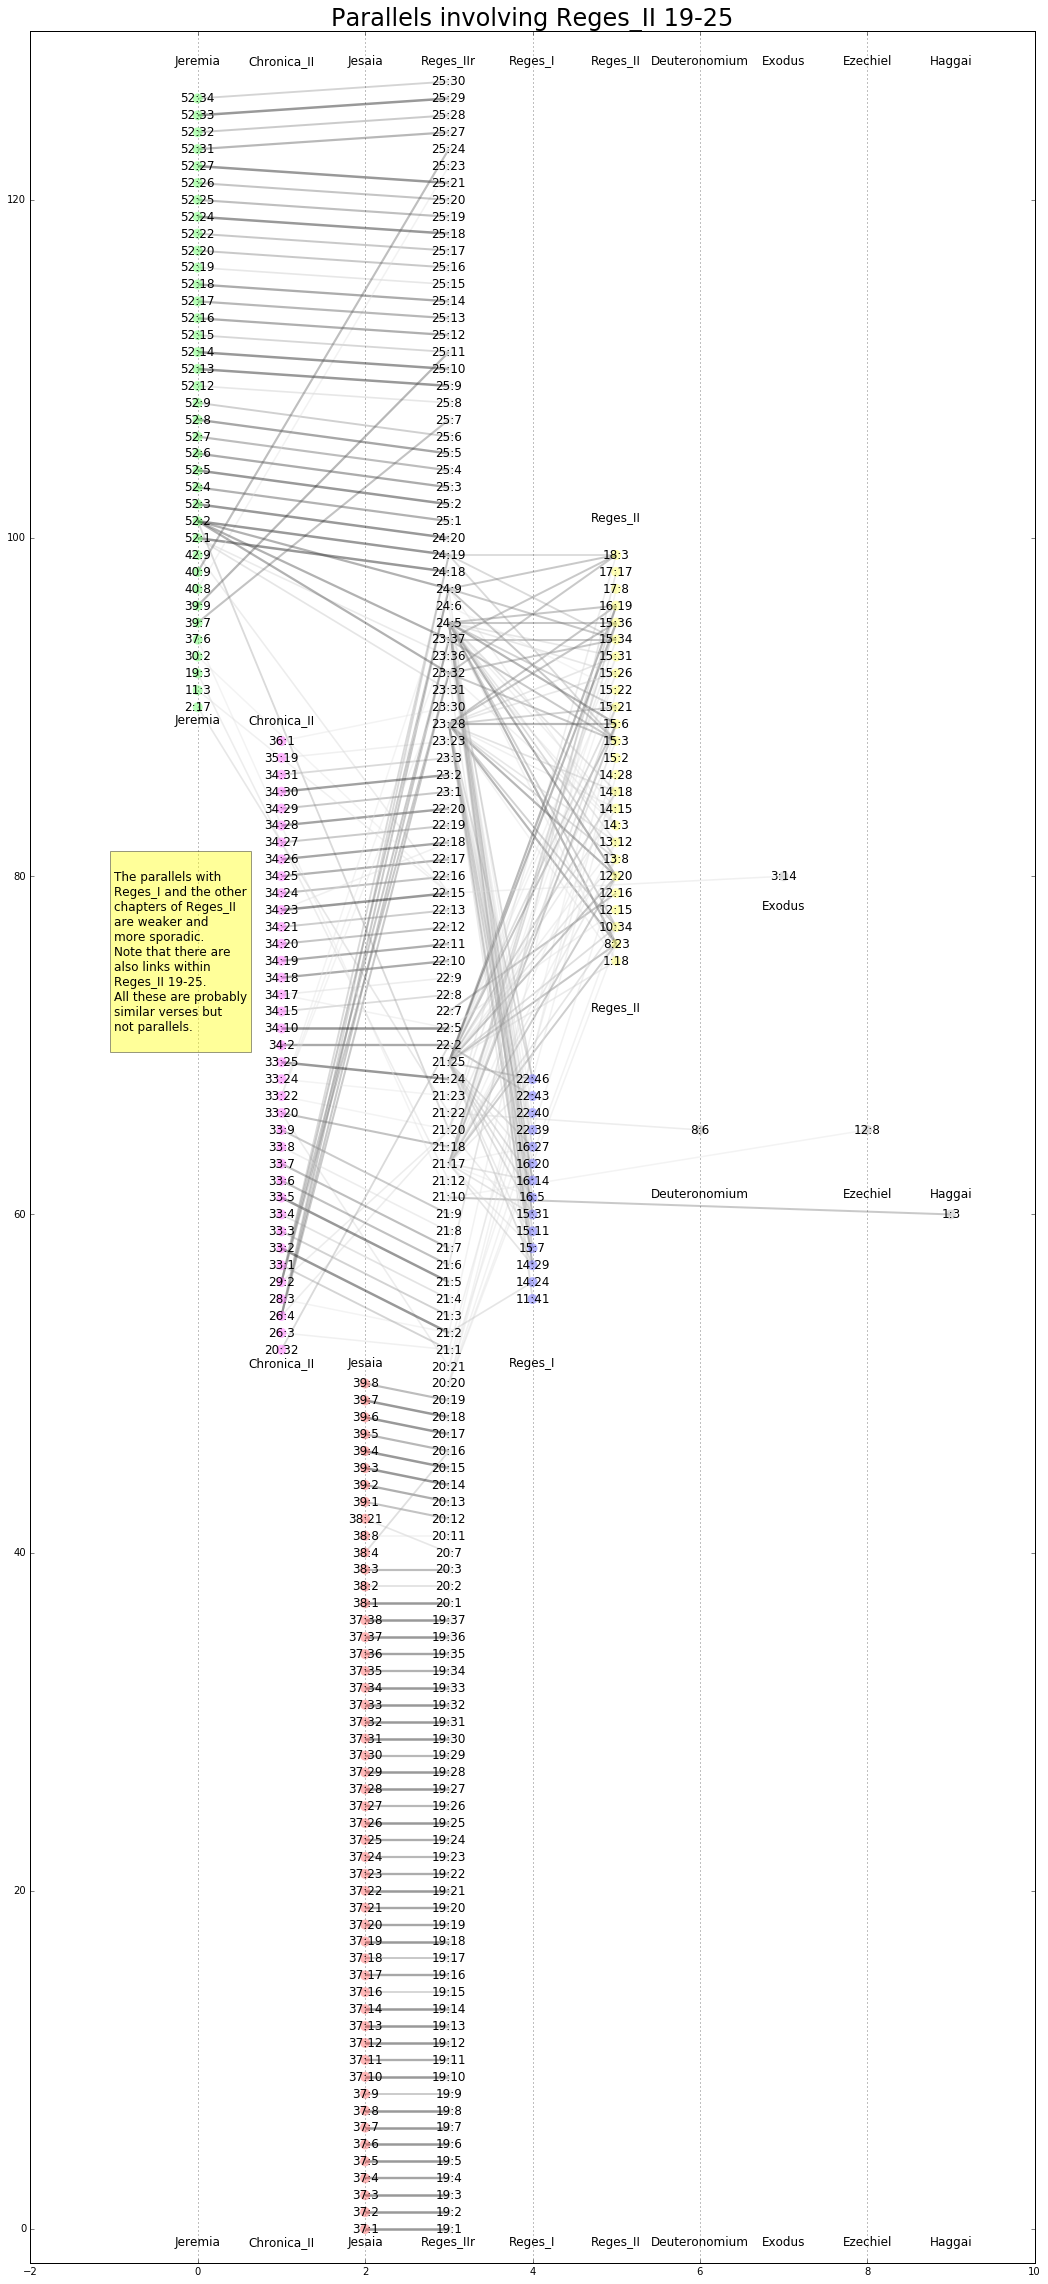

In [15]:
plt.figure(figsize=(18,40))

nx.draw_networkx(g, pos,
    width=[g.get_edge_data(*x)['weight']/40 for x in g.edges()],
    edge_color=[g.get_edge_data(*x)['weight'] for x in g.edges()],
    edge_cmap=plt.cm.Greys,
    edge_vmin=50,
    edge_vmax=100,
    node_color=ncolors,
    node_size=100,
    labels=nlabels,
    alpha=0.4,
    linewidths=0,
)
#plt.axis('tight')
plt.ylim(-2, 130)
book_font_size = 12
plt.grid(b=True, which='both', axis='x')
plt.title('Parallels involving Reges_II 19-25', fontsize=24)
plt.text(-1,70, '''
The parallels with
Reges_I and the other
chapters of Reges_II
are weaker and 
more sporadic.
Note that there are
also links within
Reges_II 19-25.
All these are probably
similar verses but
not parallels.
''', #bbox=dict(width=145, height=200, facecolor='yellow', alpha=0.4), fontsize=12)
     # suddenly the width and height keyword args are no longer accepted.
     # bbox performs an auto fit
     bbox=dict(facecolor='yellow', alpha=0.4), fontsize=12)
for (ypos, books) in (
    (-1, all_books_cust),
    (51, ['Chronica_II', 'Jesaia', 'Reges_I']),
    (61, ['Deuteronomium', 'Ezechiel', 'Haggai']),
    (72, ['Reges_II']),
    (78, ['Exodus']),
    (89, ['Chronica_II', 'Jeremia']),
    (101, ['Reges_II']),
    (128, all_books_cust),
): 
    for bk in books:
        plt.text(pos_x[bk], ypos, bk, fontsize=book_font_size, horizontalalignment='center')

plt.savefig('kings_parallels.pdf')

From the graph above we read off which are the interesting passages to compare:

Reges_II 19-20:19 with Jesaia 37-39:8

Reges_II 21-23:3 with Chronica_II 33-34:31

Reges_II 23:31-25:30 with Jeremia 52-52:34

In [16]:
focus_books = {'Reges_II', 'Jesaia', 'Jeremia', 'Chronica_II'}

# Similarity study

We have a closer look at the similarities between de passages as far as they are contained in the focus books.

We make a pairwise comparison of all sentences, based on the Levenshtein ratio (the similarity based on the Levenshtein distance).

First we divide the material up into sentences.

In [17]:
msg('Identifying sentences')
crossrefs_lcs = set()
all_sentences = set()
for v in all_verse_nodes:
    for w in L.d('word', v):
        all_sentences.add(L.u('sentence', w))
msg('Found {} sentences in {} verses'.format(len(all_sentences), len(all_verse_nodes)))

msg('Grouping sentences by verse')
focus_sentences = collections.defaultdict(set)
for s in all_sentences:
    fw = L.d('word', s)[0]
    bk = F.book.v(L.u('book', fw))
    if bk not in focus_books: continue
    ch = int(F.chapter.v(L.u('chapter', fw)))
    if bk in REFBOOKS and ch not in REFCHAPTERS: continue
    vs = int(F.verse.v(L.u('verse', fw)))
    focus_sentences[(bk, ch, vs)].add(s)

msg('Getting sentence texts')
chunks = []
chunk_data = []
for ((bk, ch, vs), sents) in sorted(focus_sentences.items()):
    for (sn, s) in enumerate(sorted(sents)):
        chunk_data.append(''.join(T.words(L.d('word', s)).replace('\n', ' ')))
        chunks.append((bk, ch, vs, sn))
msg('Done: {} sentences in {} verses'.format(len(chunks), len(focus_sentences)))
for i in range(5):
    print('{} {}'.format(chunks[i], chunk_data[i]))

    44s Identifying sentences
    44s Found 743 sentences in 296 verses
    44s Grouping sentences by verse
    44s Getting sentence texts
    44s Done: 682 sentences in 253 verses


('Chronica_II', 20, 32, 0) וַיֵּ֗לֶךְ בְּדֶ֛רֶךְ אָבִ֥יו אָסָ֖א 
('Chronica_II', 20, 32, 1) וְלֹא־סָ֣ר מִמֶּ֑נָּה לַעֲשֹׂ֥ות הַיָּשָׁ֖ר בְּעֵינֵ֥י יְהוָֽה׃ 
('Chronica_II', 26, 3, 0) בֶּן־שֵׁ֨שׁ עֶשְׂרֵ֤ה שָׁנָה֙ עֻזִּיָּ֣הוּ בְמָלְכֹ֔ו 
('Chronica_II', 26, 3, 1) וַחֲמִשִּׁ֤ים וּשְׁתַּ֨יִם֙ שָׁנָ֔ה מָלַ֖ךְ בִּירוּשָׁלִָ֑ם 
('Chronica_II', 26, 3, 2) וְשֵׁ֣ם אִמֹּ֔ו יְכָלְיָ֖ה מִן־יְרוּשָׁלִָֽם׃ 


## Comparing the sentences

We compare all sentences to each other and grab the similar pairs.

In [18]:
msg('Comparing sentences and filtering the similar ones')
chunk_dist = {}
total_chunks = len(chunks)
for i in range(total_chunks):
    c_i = chunk_data[i]
    for j in range(i + 1, total_chunks):
        c_j = chunk_data[j]
        chunk_dist[(i, j)] = round(100 * ratio(c_i, c_j))
msg('Done: {} distances'.format(len(chunk_dist)))

    51s Comparing sentences and filtering the similar ones
    52s Done: 232221 distances


 7m 01s Cut-off sizes


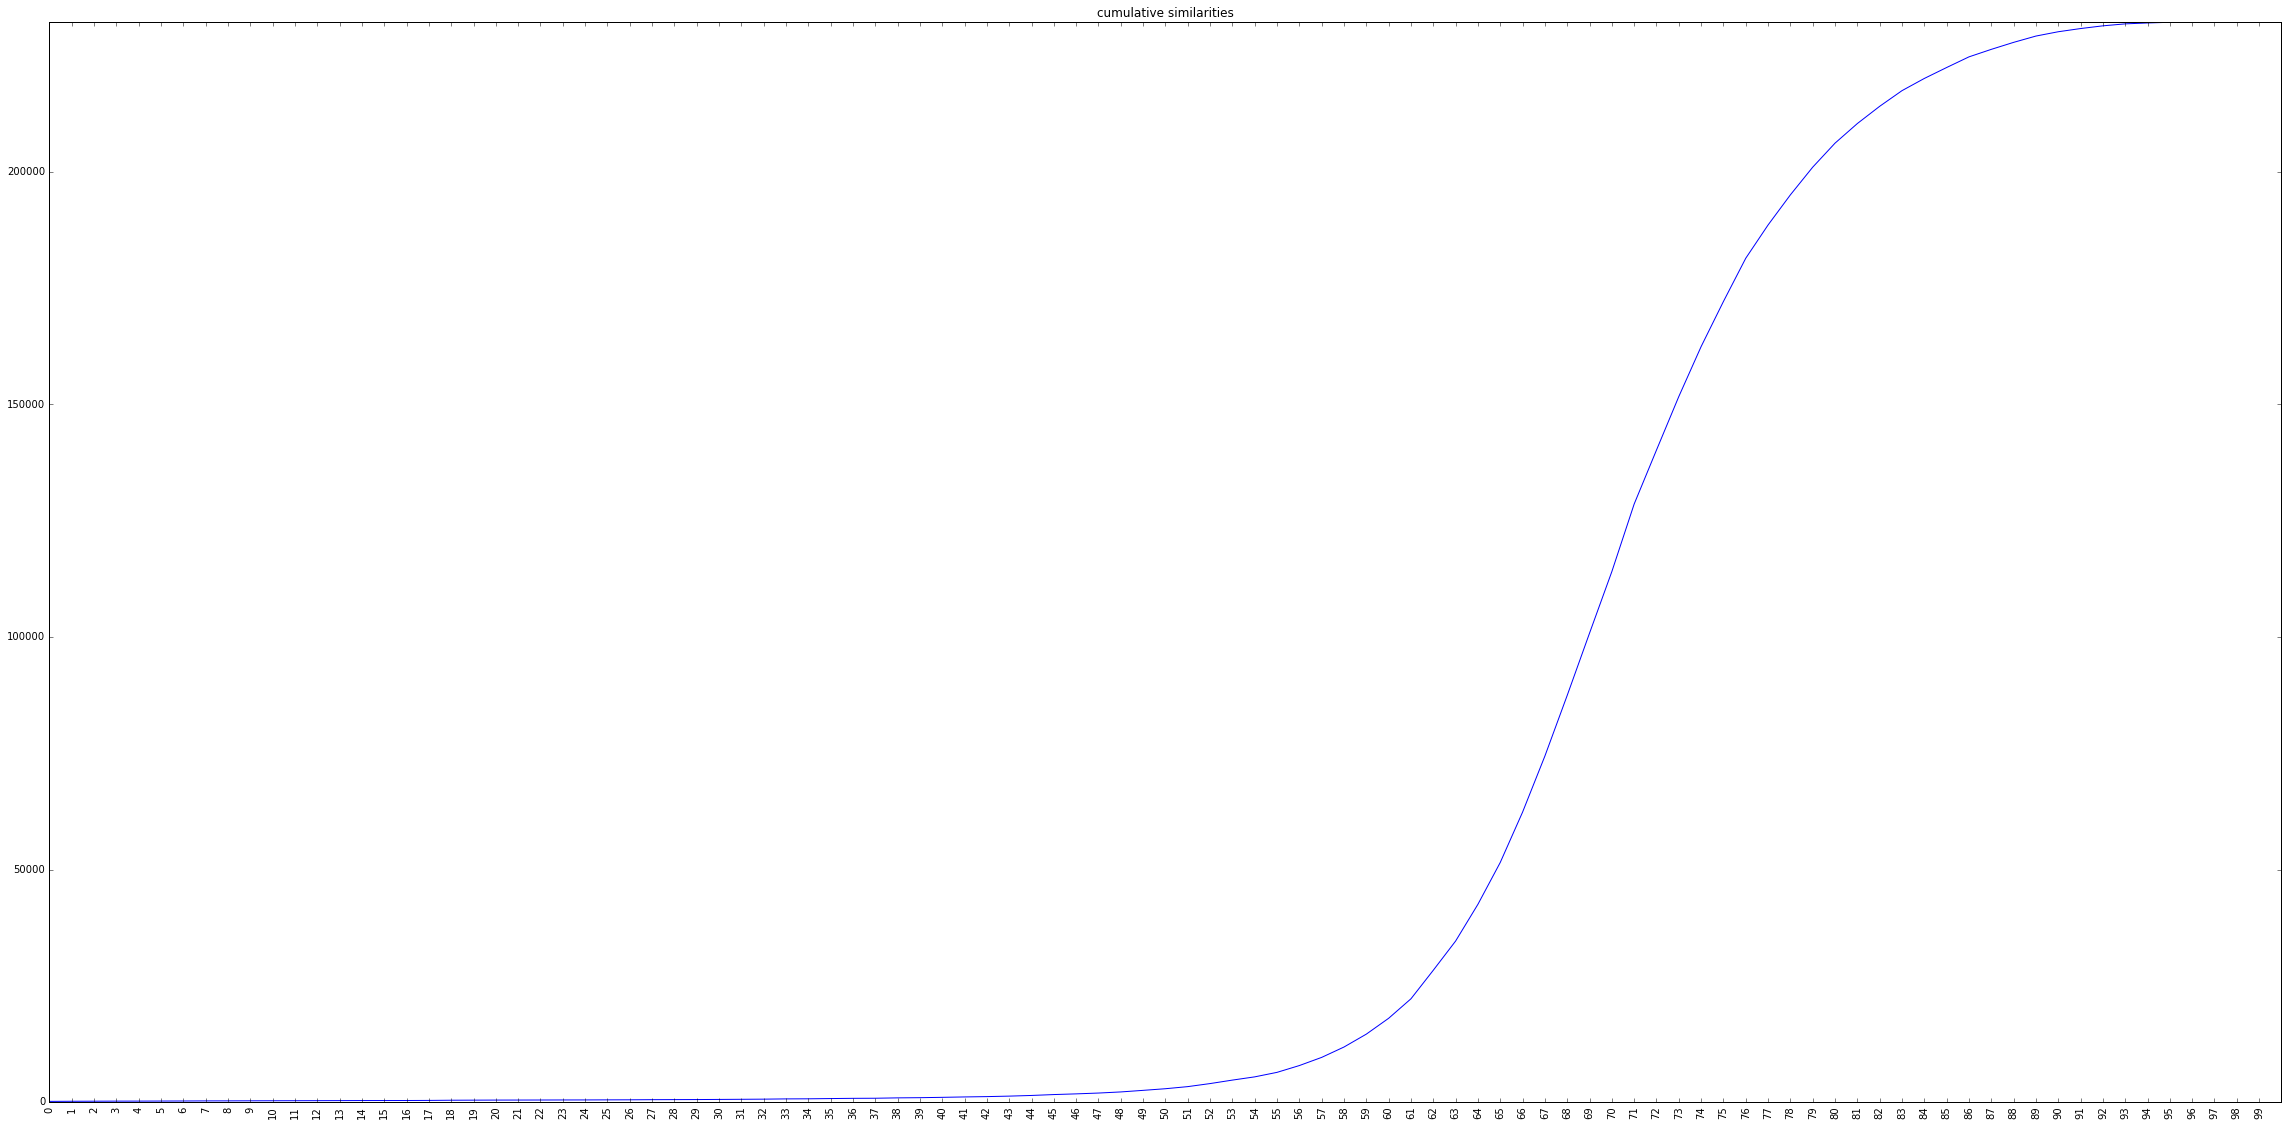

In [27]:
msg('Cut-off sizes')
sim_levels = collections.Counter()
for ((i,j), sim) in chunk_dist.items(): sim_levels[sim] += 1
cumsum = 0
sim_levels_cum = []
start = 0
end = 100

for sim in reversed(range(start, end+1)):
    cumsum += sim_levels.get(sim, 0)
    sim_levels_cum.append(cumsum)

cummax = sim_levels_cum[100]

x = range(len(sim_levels_cum))
fig = plt.figure(figsize=(40,20))
plt.plot(x[start:end], sim_levels_cum[start:end])
plt.axis([start, end, 0, cummax])
plt.xticks(x[start:end], range(start, end), rotation='vertical')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.title('cumulative similarities')
plt.savefig('kings_similarities.pdf')

## Similarity file

The full similarity file is [here](kings_similarities.tsv) (8 MB)

In [20]:
msg('Writing distances to disk')
with open(SIMILAR_FILE, 'w') as f:
    for ((i,j), sim) in sorted(chunk_dist.items()):
        f.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(*chunks[i], *chunks[j], sim))
msg('Done')

 1m 07s Writing distances to disk
 1m 09s Done


# Showing text differences

Here is a table containing all parallels in text with diff markup, plus, 
for each comparison, a table of the lexemes that are not shared by the two verses in that comparison.

In [21]:
def lex_diff(c1, c2):
    v1 = T.node_of(*c1)
    v2 = T.node_of(*c2)
    lex1 = {F.lex_utf8.v(w).rstrip('/[=') for w in L.d('word', v1)}
    lex2 = {F.lex_utf8.v(w).rstrip('/[=') for w in L.d('word', v2)}
    return (lex1-lex2, lex2-lex1)

compare_lexemes = {}
for (c1, c2, r) in crossrefs:
    compare_lexemes[(c1, c2)] = lex_diff(c1, c2)

Now we can construct a synoptic text from the data we have built up in ``normalized_passages``.

We also produce chapter diffs for the relevant chapters of Jesaja between its MT and Qumran forms.

First we make a stylesheet and html boiler plates.

In [23]:
css = '''
<style type="text/css">
table.t {
    width: 100%;
    border-collapse: collapse;
}
table.h {
    direction: rtl;
}
table.p {
    direction: ltr;
}
tr.t.tb {
    border-top: 2px solid #aaaaaa;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
tr.t.bb {
    border-bottom: 2px solid #aaaaaa;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
th.t {
    font-family: Verdana, Arial, sans-serif;
    font-size: large;
    vertical-align: middle;
    text-align: center;
    padding-left: 2em;
    padding-right: 2em;
    padding-top: 1ex;
    padding-bottom: 2ex;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
td.t {
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
    padding-left: 1em;
    padding-right: 1em;
    padding-top: 0.3ex;
    padding-bottom: 0.5ex;
}
td.h {
    font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif;
    font-size: x-large;
    line-height: 1.7;
    text-align: right;
    direction: rtl;
}
td.ld {
    font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif;
    font-size: medium;
    line-height: 1.2;
    text-align: right;
    vertical-align: top;
    direction: rtl;
    width: 10%;
}
td.p {
    font-family: Verdana, sans-serif;
    font-size: large;
    line-height: 1.3;
    text-align: left;
    direction: ltr;
}
td.vl {
    font-family: Verdana, Arial, sans-serif;
    font-size: small;
    text-align: right;
    vertical-align: top;
    color: #aaaaaa;
    width: 5%;
    direction: ltr;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
    padding-left: 0.4em;
    padding-right: 0.4em;
    padding-top: 0.3ex;
    padding-bottom: 0.5ex;
}
span.m {
    background-color: #aaaaff;
}
span.f {
    background-color: #ffaaaa;
}
span.x {
    background-color: #ffffaa;
    color: #bb0000;
}
span.delete {
    background-color: #ffaaaa;
}
span.insert {
    background-color: #aaffaa;
}
span.replace {
    background-color: #ffff00;
}
</style>
'''

diffhead = '''
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=UTF-8" />
    <title></title>
    <style type="text/css">
        table.diff {
            font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif; 
            font-size: x-large;
            text-align: right;
        }
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
    </style>
</head>
'''

html_file_tpl = '''<html>
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<title>{}</title>
{}
</head>
<body>
{}
</body>
</html>'''

Then we define the auxiliary functions to retrieve the text of the verses and to compare them with their parallels.

In [24]:
def print_label(vl, without_book=True):
    bookrep = '' if without_book else '{} '.format(vl[0])
    return '{}{}:{}'.format(bookrep, vl[1], vl[2]) if vl[0] != '' else ''

def print_diff(a, b):
    arep = ''
    brep = ''
    for (lb, ai, aj, bi, bj) in SequenceMatcher(isjunk=None, a=a, b=b, autojunk=False).get_opcodes():
        if lb == 'equal':
            arep += a[ai:aj]
            brep += b[bi:bj]
        elif lb == 'delete':
            arep += '<span class="{}">{}</span>'.format(lb, a[ai:aj])
        elif lb == 'insert':
            brep += '<span class="{}">{}</span>'.format(lb, b[bi:bj])
        else:
            arep += '<span class="{}">{}</span>'.format(lb, a[ai:aj])
            brep += '<span class="{}">{}</span>'.format(lb, b[bi:bj])
    return (arep, brep)
    
def get_vtext(v, hp):
    if hp == 'h':
        return ''.join('{}{}'.format(
            F.g_word_utf8.v(w), F.trailer_utf8.v(w)) for w in L.d('word', v),
        )
    if hp == 'p':
        return ''.join('{}{}'.format(
            F.phono.v(w), F.phono_sep.v(w)) for w in L.d('word', v),
        )
    return ''

def print_chunk(v1, v2, hp):
    vn1 = T.node_of(*v1)
    vn2 = T.node_of(*v2)
    text1 = get_vtext(vn1, hp)
    text2 = get_vtext(vn2, hp)
    (lexdiff1, lexdiff2) = lex_diff(v1, v2)
    (line1, line2) = print_diff(text1, text2)
    return '''
<tr class="t tb">
    <td class="vl">{b1}</td>
    <td class="t {hp}">{l1}</td>
    <td class="t ld"><span class="delete">{ld1}</span></td>
    <td class="t ld"><span class="insert">{ld2}</span></td>
    <td class="t {hp}">{l2}</td>
    <td class="vl">{b2}</td>
</tr>
'''.format(
    b1=print_label(v1, without_book=False),
    l1=line1,
    ld1=' '.join(sorted(lexdiff1)),
    ld2=' '.join(sorted(lexdiff2)),
    b2=print_label(v2, without_book=False), 
    l2=line2,
    hp=hp,
)

def print_passage(cmp_list, hp):
    result = []
    for item in cmp_list:
        result.append(print_chunk(item[0], item[1], hp))
    return '\n'.join(result)

def get_lex_summ(book, my_own_lex):
    result = []
    for (lex, n) in sorted(my_own_lex[book].items(), key=lambda x: (-x[1], x[0])):
        result.append('<span class="ld">{}</span>&nbsp;{}<br/>'.format(lex, n))
    return '\n'.join(result)
    
def print_lexeme_summary(book1, book2, my_own_lex):
    return '''
<tr class="t tb">
    <td class="vl">&nbsp;</td>
    <td class="t">&nbsp;</td>
    <td class="t ld"><span class="delete">{ld1}</span></td>
    <td class="t ld"><span class="insert">{ld2}</span></td>
    <td class="t">&nbsp;</td>
    <td class="vl">&nbsp;</td>
</tr>
'''.format(
        ldr=get_lex_summ(book1, my_own_lex),
        ldp=get_lex_summ(book2, my_own_lex),
    )

def print_table(hp):
    result = '''
<table class="t {}">
'''.format(hp)

    result += print_passage(sorted(crossrefs), hp)
    
    result += '''
</table>
'''
    return result

Here are the functions to make comparisons with the Qumran text.

Note that the Qumran text is unpointed, so we compare it with an unpointed representation of the Masoretic text.
We also strip the marks from the s(h)in letter, so that we ignore any distinction between sin and shin in both sources.

In [25]:
def shin(x): return x.replace(
        '\uFB2A'
        ,'ש'
).replace(
        '\uFB2B',
        'ש'
)

def lines_chapter_mt(ch):
    vn = T.node_of('Jesaia', ch, 1)
    cn = L.u('chapter', vn)
    lines = []
    for v in L.d('verse', cn):
        vl = F.verse.v(v)
        text = ''.join('{}{}'.format(
            F.g_cons_utf8.v(w), ' ' if len(F.trailer_utf8.v(w)) else '') for w in L.d('word', v))
        lines.append('{} {}'.format(vl, shin(text.strip())))
    return lines

def lines_chapter_1q(ch):
    lines = []
    for v in q1[ch]:
        text = ' '.join(q1[ch][v])
        lines.append('{} {}'.format(v, shin(text.strip())))
    return lines

def compare_chapters(c1, c2, lb1, lb2):
    dh = difflib.HtmlDiff(wrapcolumn=60)
    table_html = dh.make_table(
        c1, 
        c2, 
        fromdesc=lb1, 
        todesc=lb2, 
        context=False, 
        numlines=5,
    )
    htext = '''<html>{}<body>{}</body></html>'''.format(diffhead, table_html)
    return htext

def mt1q_chapter_diff(ch):
    lines_mt = lines_chapter_mt(ch)
    lines_1q = lines_chapter_1q(ch)
    return compare_chapters(lines_mt, lines_1q, 'Jesaia {} MT'.format(ch), 'Jesaia {} 1Q'.format(ch))

And next we produce the actual html results.

In [26]:
html_text_h = html_file_tpl.format(
    '2 Kings 19-26 and parallels [Hebrew]',
    css,
    print_table('h'),
)
html_text_p = html_file_tpl.format(
    '2 Kings 19-26 and parallels [phonetic]',
    css,
    print_table('p'),
)
ht = open('kings_parallels_h.html', 'w')
ht.write(html_text_h)
ht.close()
ht = open('kings_parallels_p.html', 'w')
ht.write(html_text_p)
ht.close()

# the Jesaja chapters with 1Q comparison
for ch in range(37,40):
    ht = open('jesaia-mt-1q_{}.html'.format(ch), 'w')
    ht.write(mt1q_chapter_diff(ch))
    ht.close()

Here are the results.
These can also be downloaded. See the top of this notebook for the list op results.